In [17]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array  # Correct imports for image processing
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import (
    EfficientNetB3,
    ResNet50,
    DenseNet121,
    MobileNetV2,
    VGG16
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Scikit-learn Libraries for Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [18]:
print("GPU Available:", tf.test.is_gpu_available())

GPU Available: True


<div style="
    background: linear-gradient(to right, #f7f8fa, #e6f2ff); 
    color: #333; 
    border-radius: 15px; 
    text-align: center; 
    font-size: 20px; 
    padding: 25px; 
    border: 2px solid #ff4d4d; 
    width: 95%; 
    margin: 30px auto; 
    box-shadow: 0 6px 12px rgba(0, 0, 0, 0.2), 0 0 15px rgba(255, 77, 77, 0.5); 
    transition: all 0.3s ease-in-out;">
    <h1 style="font-size: 28px; margin: 0; font-family: 'Arial', sans-serif;">
        <span style="
            color: #ff3333; 
            font-weight: bold; 
            text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.2);">
            Load Dataset
        </span>
    </h1>
</div>

<style>
    div:hover {
        transform: scale(1.03); /* Slight zoom on hover */
        box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3), 0 0 20px rgba(255, 77, 77, 0.7);
    }
</style>

In [19]:
# Dataset Paths
data_dir = "/kaggle/input/animal/Dataset"
train_dir = "/kaggle/input/animal/Dataset/train"
val_dir = "/kaggle/input/animal/Dataset/val"
test_dir = "/kaggle/input/animal/Dataset/test"

# Image Dimensions and Batch Size
img_size = (128, 128)  
batch_size = 16       

In [20]:
# Data Augmentation and Normalization
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [21]:
# Data Generators
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # Important for correct evaluation
)

Found 1027 images belonging to 3 classes.
Found 378 images belonging to 3 classes.
Found 358 images belonging to 3 classes.


In [22]:
# Baseline CNN Model
baseline_model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation="softmax")  # Match number of classes
])

# Compile Baseline Model
baseline_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [23]:
# Add EarlyStopping Callback
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train Baseline Model
history_baseline = baseline_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stopping]
)

# Pretrained Model with MobileNetV2
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze Base Model Layers
base_model.trainable = False

# Add Custom Layers
pretrained_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation="softmax")
])

# Compile Pretrained Model
pretrained_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train Pretrained Model
history_pretrained = pretrained_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 320ms/step - accuracy: 0.3670 - loss: 1.8153 - val_accuracy: 0.7143 - val_loss: 1.0595
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - accuracy: 0.4142 - loss: 1.0869 - val_accuracy: 0.7143 - val_loss: 0.9752
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 266ms/step - accuracy: 0.4151 - loss: 1.0773 - val_accuracy: 0.7037 - val_loss: 1.0229
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 275ms/step - accuracy: 0.3971 - loss: 1.0926 - val_accuracy: 0.7063 - val_loss: 1.0078
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 275ms/step - accuracy: 0.4170 - loss: 1.0772 - val_accuracy: 0.6958 - val_loss: 0.9814
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 271ms/step - accuracy: 0.4316 - loss: 1.0693 - val_accuracy: 0.7063 - val_loss: 0.9255
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 271ms/step - accuracy: 0.4337 - loss: 1.0576 - val_accuracy: 0.7063 - val_loss: 0.8967
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - accuracy: 0.4310 - loss: 1.0611 - val_accu

In [24]:
# Fine-tune Pretrained Model
base_model.trainable = True
pretrained_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_finetune = pretrained_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[early_stopping]
)

Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 72s 534ms/step - accuracy: 0.8360 - loss: 0.4528 - val_accuracy: 0.8783 - val_loss: 0.3387
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 277ms/step - accuracy: 0.9019 - loss: 0.2678 - val_accuracy: 0.9312 - val_loss: 0.1901
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - accuracy: 0.9187 - loss: 0.2559 - val_accuracy: 0.9683 - val_loss: 0.0955
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - accuracy: 0.9243 - loss: 0.2237 - val_accuracy: 0.9550 - val_loss: 0.1217
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 286ms/step - accuracy: 0.9282 - loss: 0.1879 - val_accuracy: 0.9259 - val_loss: 0.1718


In [25]:
# Evaluate Models
print("Evaluating Baseline Model...")
test_loss_baseline, test_accuracy_baseline = baseline_model.evaluate(test_gen)
print(f"Baseline Model Test Accuracy: {test_accuracy_baseline * 100:.2f}%")

print("Evaluating Pretrained Model...")
test_loss_pretrained, test_accuracy_pretrained = pretrained_model.evaluate(test_gen)
print(f"Pretrained Model Test Accuracy: {test_accuracy_pretrained * 100:.2f}%")

Evaluating Baseline Model...
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.5064 - loss: 1.0224
Baseline Model Test Accuracy: 68.99%
Evaluating Pretrained Model...
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.9662 - loss: 0.0847
Pretrained Model Test Accuracy: 96.65%


In [26]:
# Confusion Matrix and Classification Report
print("Generating Predictions and Reports...")
baseline_predictions = np.argmax(baseline_model.predict(test_gen), axis=1)
pretrained_predictions = np.argmax(pretrained_model.predict(test_gen), axis=1)
true_labels = test_gen.classes

print("Baseline Model Classification Report")
print(classification_report(true_labels, baseline_predictions, target_names=list(test_gen.class_indices.keys())))

print("Pretrained Model Classification Report")
print(classification_report(true_labels, pretrained_predictions, target_names=list(test_gen.class_indices.keys())))

print("Baseline Model Confusion Matrix")
print(confusion_matrix(true_labels, baseline_predictions))

print("Pretrained Model Confusion Matrix")
print(confusion_matrix(true_labels, pretrained_predictions))

Generating Predictions and Reports...
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step
Baseline Model Classification Report
              precision    recall  f1-score   support

         cat       0.00      0.00      0.00        66
         dog       0.71      0.95      0.81       250
       horse       0.38      0.24      0.29        42

    accuracy                           0.69       358
   macro avg       0.37      0.40      0.37       358
weighted avg       0.54      0.69      0.60       358

Pretrained Model Classification Report
              precision    recall  f1-score   support

         cat       0.90      0.94      0.92        66
         dog       0.98      0.98      0.98       250
       horse       1.00      0.93      0.96        42

    accuracy                           0.97       358
   macro avg       0.96      0.95      0.95       358
weighted avg       0.97      0.97      0.97       358

Baseline Model Confusion Matrix
[[  0  63 

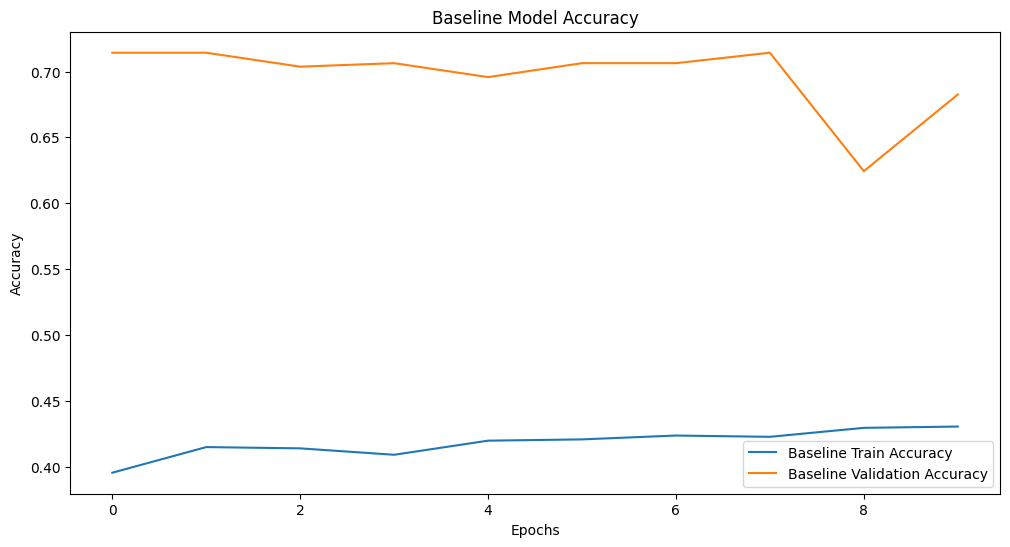

In [27]:
# Plot Training History for Baseline Model
plt.figure(figsize=(12, 6))
plt.plot(history_baseline.history['accuracy'], label='Baseline Train Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Baseline Validation Accuracy')
plt.title('Baseline Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Visualization of Training History

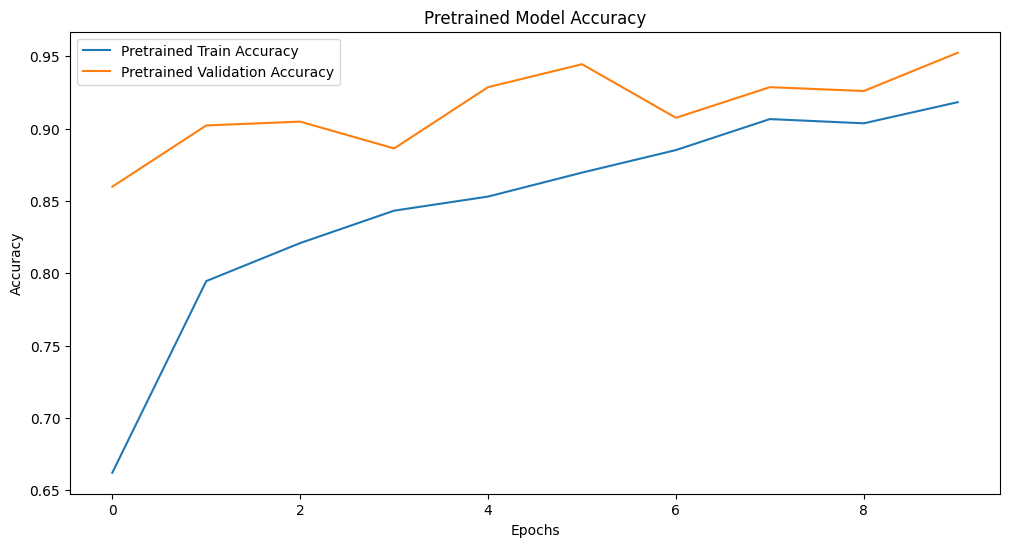

In [28]:
# Plot Training History for Pretrained Model
plt.figure(figsize=(12, 6))
plt.plot(history_pretrained.history['accuracy'], label='Pretrained Train Accuracy')
plt.plot(history_pretrained.history['val_accuracy'], label='Pretrained Validation Accuracy')
plt.title('Pretrained Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

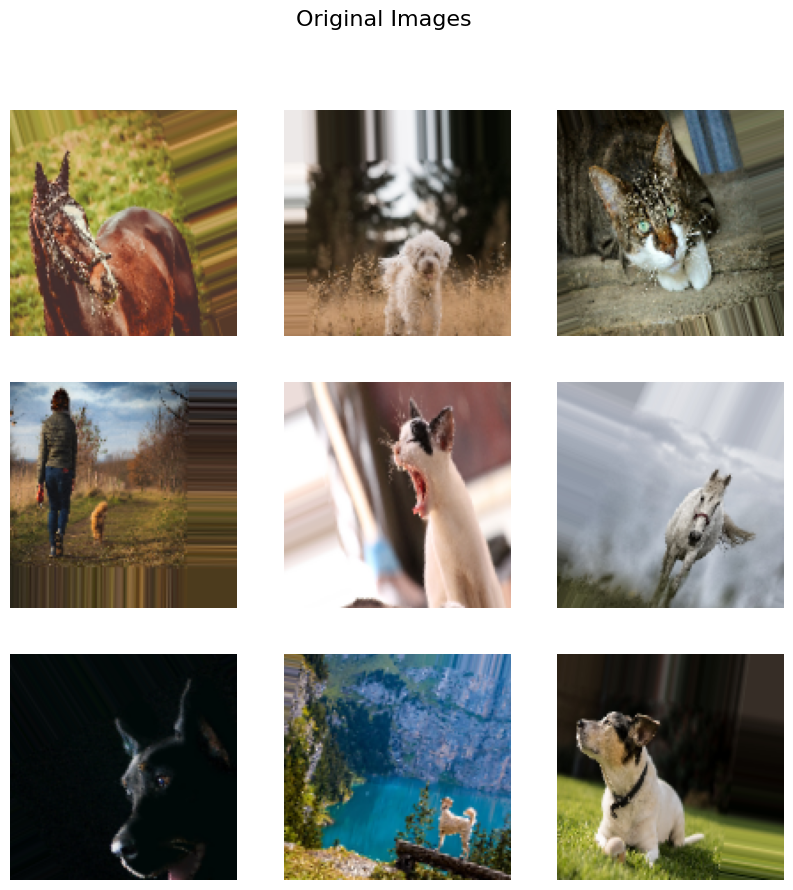

In [29]:
# Display Original Images
for batch in train_gen:  # Use train_gen instead of train_data
    images, labels = batch
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])  # No need to rescale; train_gen already normalizes
        plt.axis('off')
    plt.suptitle("Original Images", fontsize=16)
    plt.show()
    break

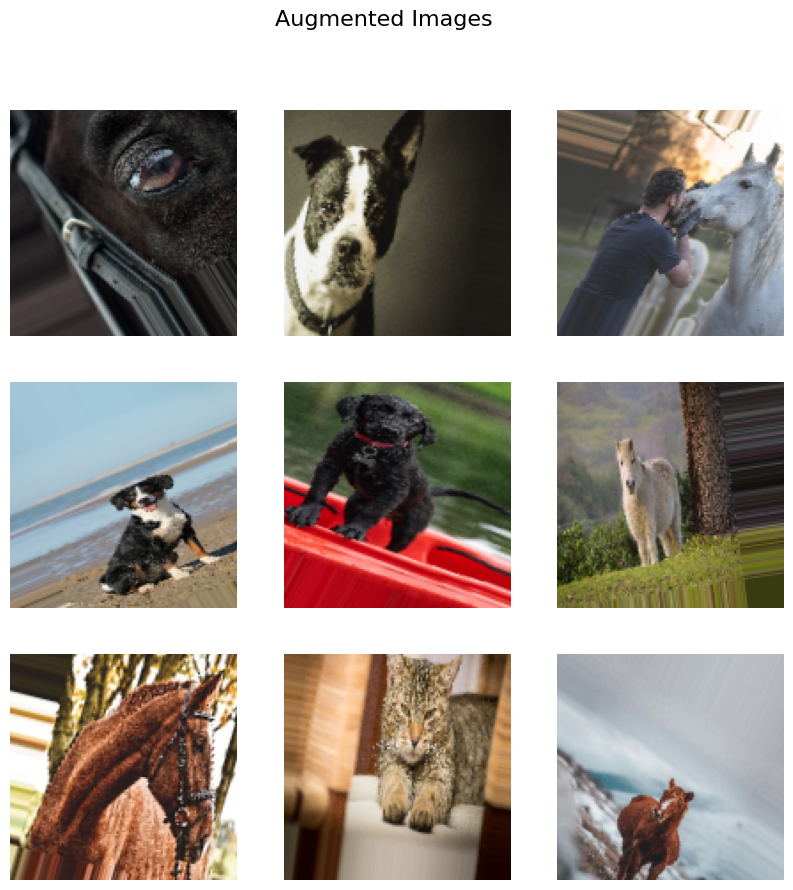

In [30]:
# Display Augmented Images
for batch in train_gen:  
    images, labels = batch  
    plt.figure(figsize=(10, 10))  
    for i in range(9):  
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i]) 
        plt.axis('off')  
    plt.suptitle("Augmented Images", fontsize=16)
    plt.show()
    break  
